<a href="https://colab.research.google.com/github/simichakma/Cleaned_Credit_Card_Fraud_Analysis/blob/main/Cleaned_Credit_Card_Fraud_Analysis_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
data = files.upload()

Saving credit_card_fraud_dataset_no_date.csv to credit_card_fraud_dataset_no_date (4).csv


In [ ]:
df = pd.read_csv('credit_card_fraud_dataset_no_date.csv')

In [ ]:
df.head()

,TransactionID,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,4189.27,688,refund,San Antonio,0
1,2,2659.71,109,refund,Dallas,0
2,3,784.00,394,purchase,New York,0
3,4,3514.40,944,purchase,Philadelphia,0
4,5,369.07,475,purchase,Phoenix,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   Amount           100000 non-null  float64
 2   MerchantID       100000 non-null  int64  
 3   TransactionType  100000 non-null  object 
 4   Location         100000 non-null  object 
 5   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [ ]:
print('Number of duplicated rows:', df.duplicated().sum())

Number of duplicated rows: 0


In [ ]:
df_new = df.drop_duplicates()

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   Amount           100000 non-null  float64
 2   MerchantID       100000 non-null  int64  
 3   TransactionType  100000 non-null  object 
 4   Location         100000 non-null  object 
 5   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [ ]:
print(df_new['IsFraud'].value_counts())

IsFraud
0    99000
1     1000
Name: count, dtype: int64


In [ ]:
fraud = df_new[df_new['IsFraud']==1]
legitimate = df_new[df_new['IsFraud']==0]

In [ ]:
print(f'Number of legitimate transactions: {len(legitimate)}')
print(f'Number of fraud transactions: {len(fraud)}')

Number of legitimate transactions: 99000
Number of fraud transactions: 1000


In [ ]:
# Upsample minority class
fraud_upsampled = resample(fraud,
                           replace=True,
                           n_samples=len(legitimate),
                           random_state=42)

In [ ]:
# Combine balanced dataset
balanced_df = pd.concat([legitimate, fraud_upsampled])

In [ ]:
# Shuffle the combined data
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
balanced_df['IsFraud'].value_counts()

,count
IsFraud,
1,99000
0,99000


In [ ]:
# Define features and labels
X = balanced_df.drop(columns='IsFraud', axis=1)
Y = balanced_df['IsFraud']

In [ ]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(198000, 5) (158400, 5) (39600, 5)


In [ ]:
# Identify columns with object (string) dtype
object_cols = X_train.select_dtypes(include=['object']).columns

# Print the unique values in the problematic columns for inspection
for col in object_cols:
    print(f'Column {col}: {X_train[col].unique()[:20]}')  # Limiting to 20 for brevity

# Convert object columns to numeric using appropriate methods:
# One-Hot Encoding for categorical features:
X_train = pd.get_dummies(X_train, columns=object_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=object_cols, drop_first=True) # Apply to test set as well

# Ensure both train and test sets have the same columns after one-hot encoding
missing_cols_test = set(X_train.columns) - set(X_test.columns)
for col in missing_cols_test:
    X_test[col] = 0  # Add missing columns to test set with 0 values
X_test = X_test[X_train.columns] # Reorder columns to match X_train

Column TransactionType: ['purchase' 'refund']
Column Location: ['New York' 'Los Angeles' 'Philadelphia' 'Phoenix' 'Chicago' 'Houston'
 'San Diego' 'San Antonio' 'Dallas' 'San Jose']


 Initialize the models

In [ ]:
# Initialize Logistic Regression model
model = LogisticRegression()

In [ ]:
# Train model
model.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
# Accuracy on training data
train_pred = model.predict(X_train)
train_acc = accuracy_score(Y_train, train_pred)
print('Accuracy on Training data:', train_acc)

Accuracy on Training data: 0.5178472222222222


In [ ]:
# Accuracy on test data
test_pred = model.predict(X_test)
test_acc = accuracy_score(Y_test, test_pred)
print('Accuracy on Test data:', test_acc)

Accuracy on Test data: 0.5181818181818182


In [ ]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)


In [ ]:
# Train the model on training data
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict on training data
train_pred = rf_model.predict(X_train)

In [ ]:
# Predict on test data
test_pred = rf_model.predict(X_test)

In [ ]:
# Calculate accuracy on training data
train_accuracy = accuracy_score(Y_train, train_pred)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 100.00%


In [ ]:
# Calculate accuracy on test data
test_accuracy = accuracy_score(Y_test, test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 100.00%


In [ ]:
# Initialize XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [ ]:
# Train the model using training data
xgb_model.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:50:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predict on training data
train_predictions = xgb_model.predict(X_train)

In [ ]:
# Predict on test data
test_predictions = xgb_model.predict(X_test)

In [ ]:
# Calculate accuracy on training data
train_accuracy = accuracy_score(Y_train, train_predictions)
print(f"Training Accuracy (XGBoost): {train_accuracy * 100:.2f}%")

Training Accuracy (XGBoost): 94.72%


In [ ]:
# Calculate accuracy on test data
test_accuracy = accuracy_score(Y_test, test_predictions)
print(f"Test Accuracy (XGBoost): {test_accuracy * 100:.2f}%")

Test Accuracy (XGBoost): 94.47%


In [ ]:
 # Initialize AdaBoost model
adaboost_model = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)


In [ ]:
# Train the AdaBoost model
adaboost_model.fit(X_train, Y_train)

AdaBoostClassifier(random_state=42)

In [ ]:
# Make predictio
train_preds = adaboost_model.predict(X_train)
test_preds = adaboost_model.predict(X_test)


In [ ]:
# Accuracy on training data
train_accuracy = accuracy_score(Y_train, train_preds)
print(f"AdaBoost Training Accuracy: {train_accuracy * 100:.2f}%")

AdaBoost Training Accuracy: 50.77%


In [ ]:
# Accuracy on test data
test_accuracy = accuracy_score(Y_test, test_preds)
print(f"AdaBoost Test Accuracy: {test_accuracy * 100:.2f}%")

AdaBoost Test Accuracy: 50.81%


In [ ]:
# Initialize
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
dt_model.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
Y_train_pred = dt_model.predict(X_train)
Y_test_pred = dt_model.predict(X_test)

In [ ]:
# Accuracy scores
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)


In [ ]:
print(f"Accuracy on Training Data: {train_accuracy * 100 :.2f}%")
print(f" Accuracy on Test Data: {test_accuracy * 100 :.2f}%")

Accuracy on Training Data: 88.44%
 Accuracy on Test Data: 87.86%


In [ ]:
# Initialize the CatBoost Classifier
cat_model = CatBoostClassifier(verbose=0, random_state=42)


In [ ]:
# Train the model
cat_model.fit(X_train, Y_train)

In [ ]:
Y_train_pred = cat_model.predict(X_train)
Y_test_pred = cat_model.predict(X_test)

In [ ]:
# Accuracy scores
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)

In [ ]:
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 97.90%
Test Accuracy: 97.44%


In [ ]:
# Initialize the model
lgb_model = LGBMClassifier(random_state=42)

In [ ]:
# Train the model
lgb_model.fit(X_train, Y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 79200, number of negative: 79200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 158400, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [ ]:
Y_train_pred = lgb_model.predict(X_train)
Y_test_pred = lgb_model.predict(X_test)

In [ ]:
# Accuracy scores
train_accuracy = accuracy_score(Y_train, Y_train_pred)
test_accuracy = accuracy_score(Y_test, Y_test_pred)

In [ ]:
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Training Accuracy: 51.78%
Test Accuracy: 51.82%


Confusion Matrix

In [ ]:
# Get the confusion matrix
cm = confusion_matrix(Y_test, Y_test)


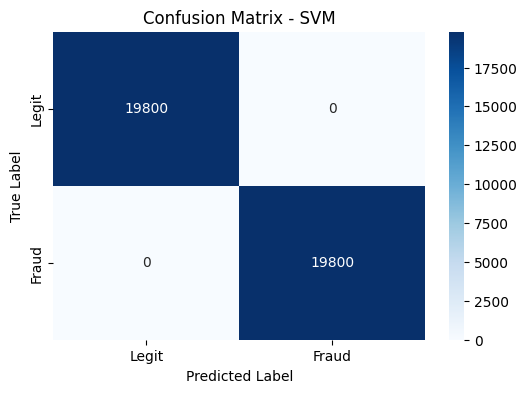

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Legit", "Fraud"], yticklabels=["Legit", "Fraud"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()

In [ ]:
# Unpack the confusion matrix
TN, FP, FN, TP = cm.ravel()
total = cm.sum()

In [ ]:
# Display percentages
print("Confusion Matrix (%):")
print(f"True Positives (TP): {TP} ({(TP/total)*100:.2f}%)")
print(f"True Negatives (TN): {TN} ({(TN/total)*100:.2f}%)")
print(f"False Positives (FP): {FP} ({(FP/total)*100:.2f}%)")
print(f"False Negatives (FN): {FN} ({(FN/total)*100:.2f}%)")

Confusion Matrix (%):
True Positives (TP): 19800 (50.00%)
True Negatives (TN): 19800 (50.00%)
False Positives (FP): 0 (0.00%)
False Negatives (FN): 0 (0.00%)


All model precision, recall and f-1 score result

In [ ]:
# Train the model
lr = LogisticRegression()
lr.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
Y_pred_lr = lr.predict(X_test)

In [ ]:
Y_pred = Y_pred_lr

In [ ]:
# Calculate metrics
precision = precision_score(Y_test, Y_pred) * 100
recall = recall_score(Y_test, Y_pred) * 100
f1 = f1_score(Y_test, Y_pred) * 100

In [ ]:
print("Logistic Regression Metrics (%):")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Logistic Regression Metrics (%):
Precision: 52.11%
Recall: 44.97%
F1 Score: 48.28%


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Predict on the test set
Y_pred_rf = rf.predict(X_test)

In [ ]:
Y_pred = Y_pred_rf

In [ ]:
precision = precision_score(Y_test, Y_pred) * 100
recall = recall_score(Y_test, Y_pred) * 100
f1 = f1_score(Y_test, Y_pred) * 100

In [ ]:
print("Random Forest Metrics (%):")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")


Random Forest Metrics (%):
Precision: 99.99%
Recall: 100.00%
F1 Score: 100.00%


In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:51:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
Y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
precision = precision_score(Y_test, Y_pred_xgb) * 100
recall = recall_score(Y_test, Y_pred_xgb) * 100
f1 = f1_score(Y_test, Y_pred_xgb) * 100

In [ ]:
print("XGBoost Metrics (%):")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

XGBoost Metrics (%):
Precision: 90.80%
Recall: 98.96%
F1 Score: 94.71%


In [ ]:
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_model.fit(X_train, Y_train)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [ ]:
Y_pred_ada = adaboost_model.predict(X_test)

In [ ]:
precision = precision_score(Y_test, Y_pred_ada) * 100
recall = recall_score(Y_test, Y_pred_ada) * 100
f1 = f1_score(Y_test, Y_pred_ada) * 100

In [ ]:
print("AdaBoost Metrics (%):")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

AdaBoost Metrics (%):
Precision: 50.42%
Recall: 98.12%
F1 Score: 66.61%


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

In [ ]:
dt_model.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# Predict on test data
Y_pred_dt = dt_model.predict(X_test)

In [ ]:
precision = precision_score(Y_test, Y_pred_dt) * 100
recall = recall_score(Y_test, Y_pred_dt) * 100
f1 = f1_score(Y_test, Y_pred_dt) * 100

In [ ]:
print("Decision Tree Metrics (%):")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

Decision Tree Metrics (%):
Precision: 98.79%
Recall: 100.00%
F1 Score: 99.39%


In [ ]:
# Initialize model
cat_model = CatBoostClassifier(verbose=0, random_state=42)
# Train model
cat_model.fit(X_train, Y_train)

In [ ]:
Y_pred_cat = cat_model.predict(X_test)

In [ ]:
precision = precision_score(Y_test, Y_pred_cat) * 100
recall = recall_score(Y_test, Y_pred_cat) * 100
f1 = f1_score(Y_test, Y_pred_cat) * 100

In [ ]:
print(" CatBoost Classifier Evaluation Metrics (%):")
print(f"Precision: {precision:.2f}%")
print(f"Recall:    {recall:.2f}%")
print(f"F1 Score:  {f1:.2f}%")

 CatBoost Classifier Evaluation Metrics (%):
Precision: 95.12%
Recall:    100.00%
F1 Score:  97.50%


In [ ]:
# Initialize the LightGBM model
lgb_model = LGBMClassifier(random_state=42)
# Train the model on training data
lgb_model.fit(X_train, Y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 79200, number of negative: 79200
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 784
[LightGBM] [Info] Number of data points in the train set: 158400, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [ ]:
Y_pred_lgb = lgb_model.predict(X_test)

In [ ]:
precision = precision_score(Y_test, Y_pred_lgb) * 100
recall = recall_score(Y_test, Y_pred_lgb) * 100
f1 = f1_score(Y_test, Y_pred_lgb) * 100

In [ ]:
print(" LightGBM Evaluation Metrics (%):")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1 Score: {f1:.2f}%")

 LightGBM Evaluation Metrics (%):
Precision: 83.71%
Recall: 94.02%
F1 Score: 88.57%
